In [1]:
from neo import Block
from neo.io import Spike2IO, NeoMatlabIO
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from kaveh.behavioral.oculomotor.trial import trial
from kaveh.sorting import spikesorter
from kaveh.toolbox import find_file
from kaveh.plots import axvlines
import numpy as np
from matplotlib import pyplot as plt
from smr import File
import csv
import os
import gc

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [7]:
# These are Buckley files with the following event structure:
# Event 0
# Event 1
# Event 2
# Event 3 : Trial onset
# Event 4 : Primary target presentation in adaptation trials
# Event 5 : Corrective target presentation in adaptation trials
# Event 6 : Divide each trial into its target jumps
# Event 7 : 
buckley_files_correct_events = ['B082107_1340_List.smr',
'B090407_1526_List.smr',
'B091208_1545_List.smr',
'B091608_1208_List.smr',
'B091707_1414_List.smr', 
'B091908_1_1500_List.smr', 
'B091908_2_1550_List.smr',
'B093008_1149_List.smr',
'B100308_2_1403_List.smr',
'B101707_1333_List.smr',
'B121407_1_1124_List.smr',
'W091008_1241_List.smr',
'W091208_1337_List.smr',
'W120108_1622_List.smr',
'W120208_1_1418_List.smr',
'W120308_2_1714_List.smr',
'W120508_1_1420_List.smr',
'W120508_2_1628_List.smr']

f_index = 0
f_name = find_file(buckley_files_correct_events[f_index], '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
f_name_csv = find_file(buckley_files_correct_events[f_index]+'.pkl.csv', '../data/david_neurons')
print(f_name)
print(f_name_csv)
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B110807/B110807_1632_List.smr'

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr
../data/david_neurons/B082107/B082107_1340_List.smr.pkl.csv


In [3]:
f_name = '../data/david_neurons/B091208/B091208_1554_Adapt.smr'

In [8]:
find_file(os.path.basename(f_name), '/mnt/papers/Herzfeld_Nat_Neurosci_2018/')

'/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091208/B091208_1554_Adapt.smr'

In [4]:
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]

In [5]:
# Load voltage
signal = seg.analogsignals[-1].as_array()
t_signal = seg.analogsignals[-1].times
signal_fs = seg.analogsignals[-1].sampling_rate

<IPython.core.display.Javascript object>


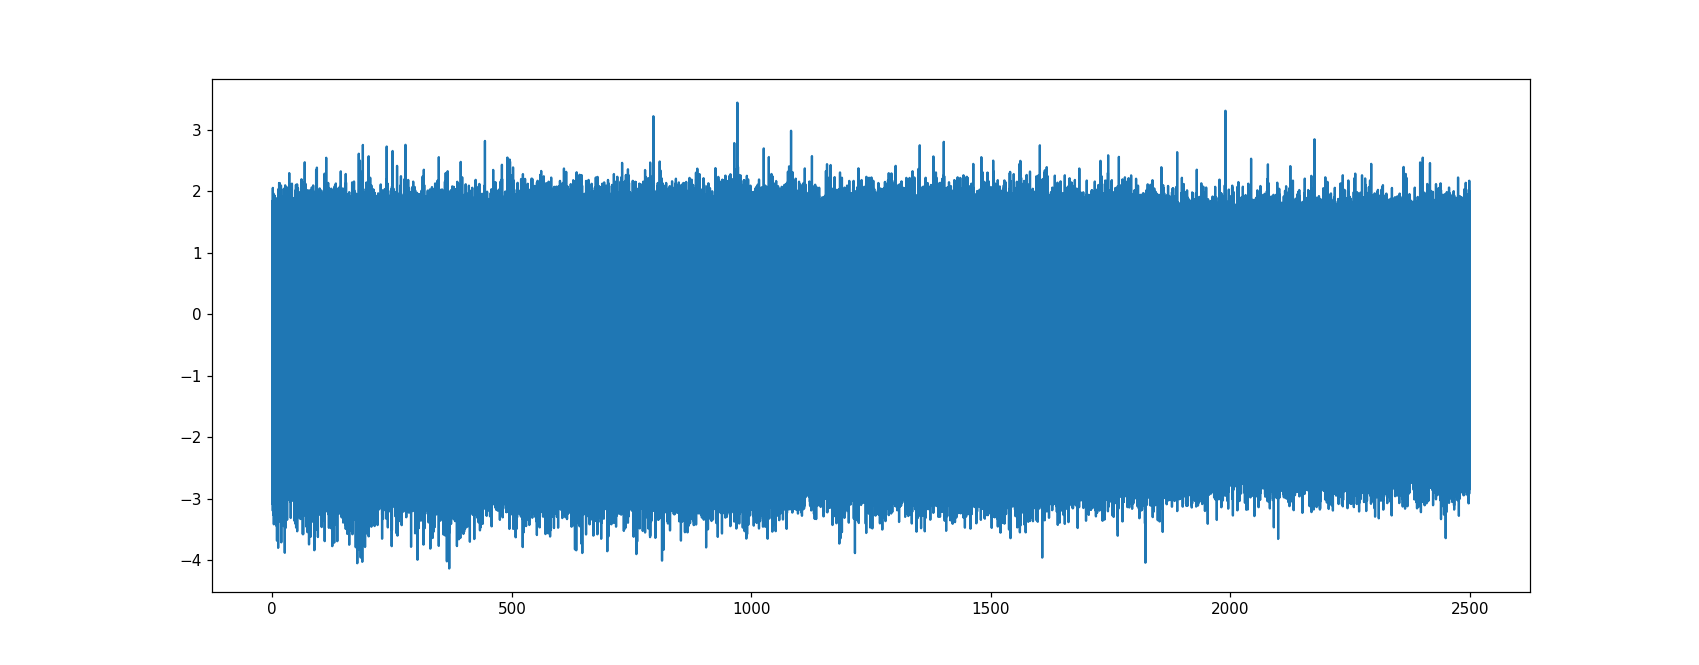

In [6]:
plt.figure()
plt.plot(t_signal, signal)

In [13]:
from neo.io import NeoMatlabIO

In [15]:
input_filename = f_name
output_filename = os.path.join('/mnt/data/ehsan/', os.path.basename(f_name) + '.mat')
r = Spike2IO(filename=input_filename)
w = NeoMatlabIO(filename=output_filename)
seg = r.read_segment()
bl = Block(name='converted')
bl.segments.append(seg)
w.write_block(bl)

In [9]:
output_filename = os.path.join('/mnt/data/ehsan/', os.path.basename(f_name) + '.mat')

In [17]:
os.path.join('/mnt/data/ehsan/', os.path.basename(f_name) + '.mat')

'/mnt/data/ehsan/B091208_1554_Adapt.smr.mat'

In [10]:
cs_times = seg.spiketrains[0].times
cs_times.shape

(4648,)

In [37]:
float(signal_fs)

50000.00000000001

In [24]:
import scipy.signal
import scipy.fftpack

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.lfilter(b, a, data)
    return y


In [53]:
signal_lfp = butter_bandpass_filter(np.squeeze(signal), 0.01, 300, float(signal_fs), order=2 )

In [59]:
lfp_sec = signal_lfp[(t_signal > start_time) & (t_signal <= end_time)]

<IPython.core.display.Javascript object>


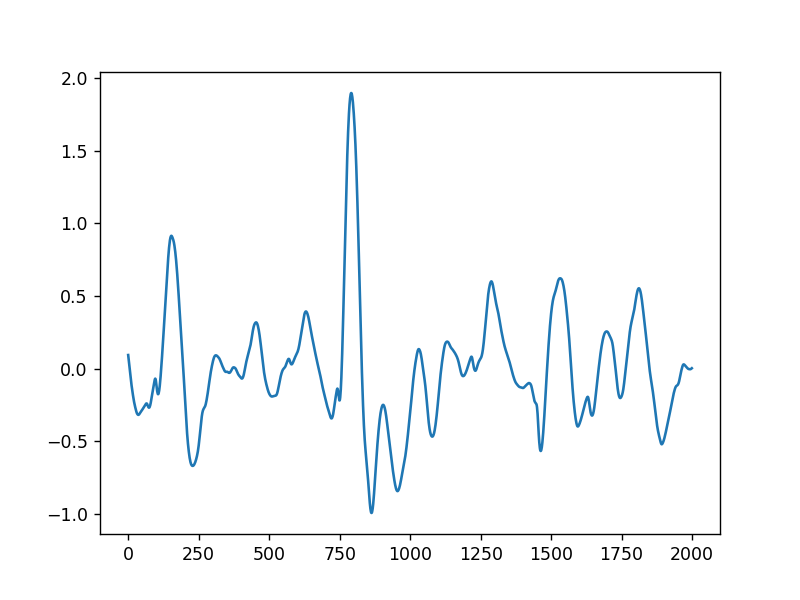

In [60]:
plt.figure()
plt.plot(lfp_sec)

<IPython.core.display.Javascript object>


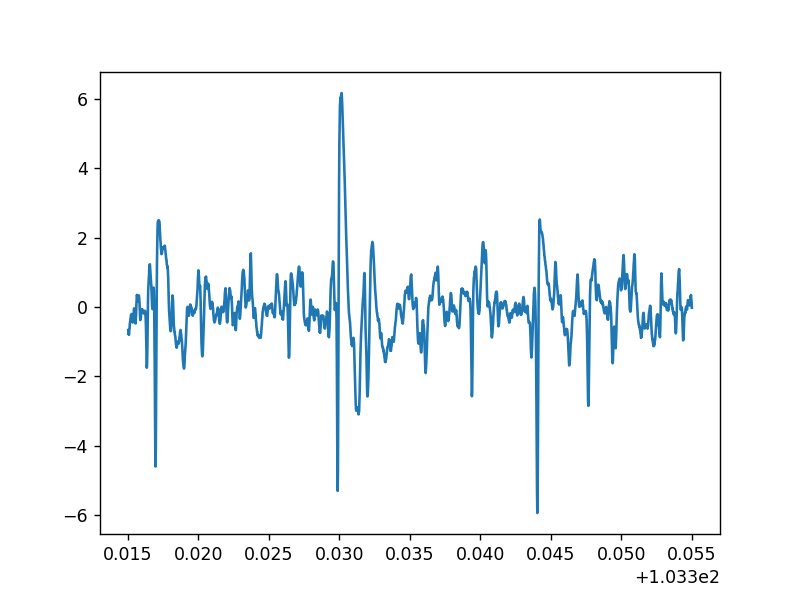

<IPython.core.display.Javascript object>


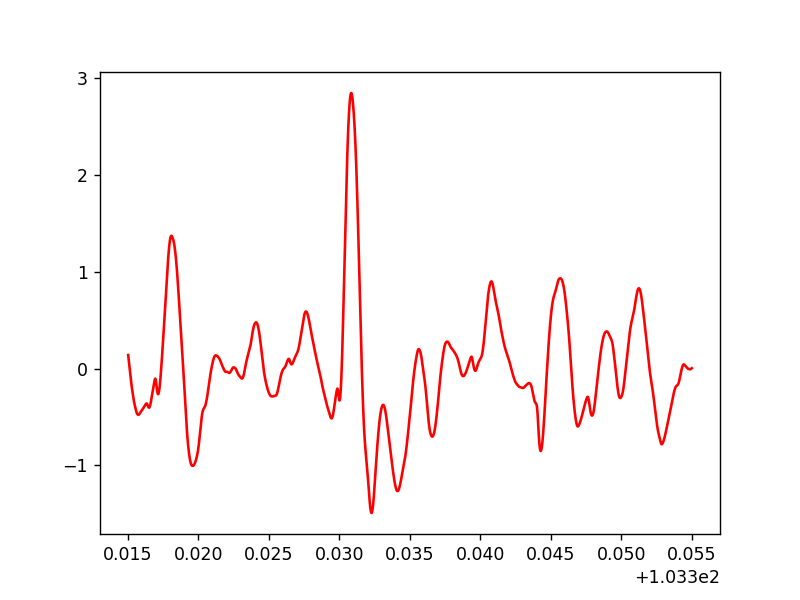

In [63]:
import quantities as pq

cst = cs_times[117]
 
start_time = cst - pq.quantity.Quantity(0.015, 's')
end_time = cst + pq.quantity.Quantity(0.025, 's')
sig_sec = signal[(t_signal > start_time) & (t_signal <= end_time)]
t_sec = t_signal[(t_signal > start_time) & (t_signal <= end_time)]
plt.figure()
plt.plot(t_sec,sig_sec)

plt.savefig('../data/signal_plot.svg')
plt.figure()
plt.plot(t_sec, lfp_sec*1.5, 'r')
plt.savefig('../data/lfp_plot.svg')